# The Battle of Neighborhoods (Week 2)
*Created by Puneet Narula*
In this assignment, I have explored, segmented, and clustered the neighborhoods in the city of Dublin based on the postal districts

For the Dublin Postal Districts, a Wikipedia page exists that has all the information I needed to explore and cluster the distircts in Dublin. Scraped the Wikipedia page and wrangled the data, cleaned it, and then read it into a pandas dataframe so that it is in a structured format.


Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [15]:
#!pip install beautifulsoup4
#!conda install -c conda-forge geopy --yes
#!conda install -c conda-forge folium=0.5.0 --yes
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import requests # convert an address into latitude and longitude values
import json # library to handle JSON files

from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt # for graphical usage 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print('Libraries imported.')

Libraries imported.


## 1. Download and Explore Dataset

Dublin postal district table is extracted from Wikipedia. Dublin has 22 postal districts. County Dublin goes beyond these postal districts, which is not covered in this analysis.

In [16]:
#extracting Dublin Neighborhoods using dublin postcodes
source = requests.get("https://en.wikipedia.org/wiki/List_of_Dublin_postal_districts").text
soup = BeautifulSoup(source, 'lxml')

soup.find('table')

df_dublin1 = pd.DataFrame()

table=soup.find('table')
for row in table.findAll('tr'):
    col = row.find_all("td")
    if (col != []):
        for i in range(0, len(col)):
                       neighborhood= col[i].text.split('(')[0]
                       df_dublin1 = df_dublin1.append({"Neighorhood":neighborhood},ignore_index=True)

df_dublin2 = df_dublin1[df_dublin1['Neighorhood'].str.contains('Dublin')]

df_dublin = df_dublin2[:-1]
df_dublin.reset_index(drop=True,inplace=True)
df_dublin

,Neighorhood
0,Dublin 1
1,Dublin 2
2,Dublin 3
3,Dublin 4
4,Dublin 5
5,Dublin 6
6,Dublin 7
7,Dublin 6W
8,Dublin 9
9,Dublin 8


The wikipedia page did not have coordinates for Dublin postal districts. I used Nominatim Geocoding service, which is built on top of OpenStreetMap data.
1. We first delay our Geocoding 1 second between each address. This is convenient when you are Geocoding a large number of physical addresses as the Geocoding service provider can deny access to the service.
2. Create a df['location'] column by applying geocode we created.
3. Third, we can create latitude, longitude, and altitude as a single tuple column.
4. Finally, We split latitude, longitude, and altitude columns into three separate columns.

In [17]:
from geopy.extra.rate_limiter import RateLimiter
locator = Nominatim(user_agent='Geocoder')
# 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# 2- - create location column
df_dublin['location'] = df_dublin['Neighorhood'].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
df_dublin['point'] = df_dublin['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
df_dublin[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df_dublin['point'].tolist(), index=df_dublin.index)


C:\Users\narul\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\narul\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Droping the columns which are not required.

In [18]:
df_dublin.drop(labels=['location', 'point','altitude'], axis=1, inplace=True)

df_dublin

,Neighorhood,latitude,longitude
0,Dublin 1,53.352488,-6.256646
1,Dublin 2,53.338971,-6.252679
2,Dublin 3,53.361223,-6.185467
3,Dublin 4,53.327507,-6.227486
4,Dublin 5,53.383454,-6.181923
5,Dublin 6,53.317698,-6.259525
6,Dublin 7,53.360551,-6.284470
7,Dublin 6W,53.309282,-6.299435
8,Dublin 9,53.386050,-6.245577
9,Dublin 8,53.350263,-6.320213


#### Use geopy library to get the latitude and longitude values of Dublin


In [19]:
address = "Dublin, Ireland"

geolocator = Nominatim(user_agent = "dublin_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print("The geographical coorinates of Dublin are {}, {}.".format(latitude, longitude))

The geographical coorinates of Dublin are 53.3497645, -6.2602732.


#### Create a map of Dublin with postal districts superimposed on top

In [20]:
map1 = folium.Map(location=[latitude, longitude], zoom_start=10)
for lat, lng, name in zip(
        df_dublin['latitude'],
        df_dublin['longitude'],
        df_dublin['Neighorhood']):
    label = '{}, {}'.format(name, 'Dublin')
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        tooltip=label,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map1)  

map1

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [21]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20210331' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RJMFRVHYH3XLM1YX2YSIF1PYQWTLSFJH3ALGGPTRCFLV3VGQ
CLIENT_SECRET:RLVAIIQ52O13OSWOABM1NVTWNDYJ1JEWW1WAVU5NI1PTWOWY


## 2. Explore Postal Districts in Dublin

#### Let's create a function to extract venue and categories from Four Square API, clean the JSON and structure it into pandas dataframe

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each postal district  and create a new dataframe

In [23]:
dublin_venues = getNearbyVenues(names=df_dublin['Neighorhood'],
                                   latitudes=df_dublin['latitude'],
                                   longitudes=df_dublin['longitude']
                                  )

In [24]:
dublin_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Dublin 1,53.352488,-6.256646,147 Deli,53.353410,-6.259807,Deli / Bodega
1,Dublin 1,53.352488,-6.256646,Holiday Inn Express Dublin City Centre Hotel,53.352306,-6.260955,Hotel
2,Dublin 1,53.352488,-6.256646,The Celt,53.350442,-6.255071,Pub
3,Dublin 1,53.352488,-6.256646,The Hop House (Kim Chi),53.352981,-6.260772,Korean Restaurant
4,Dublin 1,53.352488,-6.256646,Gate Theatre,53.353113,-6.261997,Theater


In [25]:
dublin_venues.shape

(700, 7)

Removing some of the categories which are public offices or related to colleges

In [26]:
venues = ['Post Office','Sculpture Garden',
'Scenic Lookout','Monument / Landmark','College Library',
'Stadium','Outdoor Sculpture','Playground',
'Convention Center','Hockey Field',
'Advertising Agency','Bus Stop','Business Service','Canal','Castle','Construction & Landscaping',
'Cricket Ground', 'Park', 'Hotel','Garden','Historic Site','Electronics Store','IT Services',
'Golf Course','Gas Station','Market','Home Service','Stables','Soccer Field','Train Station',
'Beach','Rugby Pitch','Music Venue']

dublin_venues.drop(dublin_venues[dublin_venues['Venue Category'].isin(venues)].index, inplace = True)

#### Create a map of Dublin with  venues superimposed on top

In [27]:
map_dublin = folium.Map(location=[latitude, longitude], zoom_start=12)
for lat, lng, name in zip(
        dublin_venues['Venue Latitude'],
        dublin_venues['Venue Longitude'],
        dublin_venues['Venue']):
    label = '{}, {}'.format(name, 'Dublin')
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dublin)  

map_dublin

Initial view of the map superimposed with venues showed clusters of venues, which are high population areas with business centres. 

#### Let's check the size of the resulting dataframe

In [28]:
print (dublin_venues.shape)
dublin_venues.head()

(601, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Dublin 1,53.352488,-6.256646,147 Deli,53.353410,-6.259807,Deli / Bodega
2,Dublin 1,53.352488,-6.256646,The Celt,53.350442,-6.255071,Pub
3,Dublin 1,53.352488,-6.256646,The Hop House (Kim Chi),53.352981,-6.260772,Korean Restaurant
4,Dublin 1,53.352488,-6.256646,Gate Theatre,53.353113,-6.261997,Theater
5,Dublin 1,53.352488,-6.256646,"Laine, my love",53.351320,-6.251253,Café


Let's check how many venues were returned for each postal district

In [29]:
dublin_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Dublin 1,90,90,90,90,90,90
Dublin 10,2,2,2,2,2,2
Dublin 11,5,5,5,5,5,5
Dublin 12,13,13,13,13,13,13
Dublin 13,46,46,46,46,46,46
Dublin 14,7,7,7,7,7,7
Dublin 15,58,58,58,58,58,58
Dublin 16,4,4,4,4,4,4
Dublin 17,9,9,9,9,9,9


#### Let's find out how many unique categories can be curated from all the returned venues

In [30]:
print('There are {} uniques categories.'.format(len(dublin_venues['Venue Category'].unique())))

There are 130 uniques categories.


## 3. Analyze Each Postal District

In [31]:
# one hot encoding
dublin_onehot = pd.get_dummies(dublin_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dublin_onehot['Neighborhood'] = dublin_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [dublin_onehot.columns[-1]] + list(dublin_onehot.columns[:-1])
dublin_onehot = dublin_onehot[fixed_columns]

dublin_onehot.head()

,Neighborhood,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Bar,Betting Shop,Bike Rental / Bike Share,Bistro,Bookstore,Bowling Alley,Breakfast Spot,Burger Joint,Burrito Place,Cafeteria,Café,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Deli / Bodega,Department Store,Dim Sum Restaurant,Diner,Discount Store,Donut Shop,Escape Room,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,French Restaurant,Furniture / Home Store,Gastropub,Gay Bar,Gelato Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Health Food Store,History Museum,Hobby Shop,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lingerie Store,Liquor Store,Lounge,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multiplex,Museum,Music Store,Nail Salon,North Indian Restaurant,Optical Shop,Other Great Outdoors,Outlet Store,Paper / Office Supplies Store,Pastry Shop,Pedestrian Plaza,Pet Store,Pharmacy,Pier,Pizza Place,Plaza,Pool Hall,Portuguese Restaurant,Pub,Rental Car Location,Rest Area,Restaurant,Salad Place,Sandwich Place,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Soccer Stadium,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park,Toy / Game Store,Trail,Tram Station,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop
0,Dublin 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Dublin 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Dublin 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Dublin 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5,Dublin 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [32]:
dublin_onehot.shape

(601, 131)

#### Next, let's group rows by postal district and by taking the mean of the frequency of occurrence of each category

In [33]:
dublin_grouped = dublin_onehot.groupby('Neighborhood').mean().reset_index()
dublin_grouped

,Neighborhood,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Bar,Betting Shop,Bike Rental / Bike Share,Bistro,Bookstore,Bowling Alley,Breakfast Spot,Burger Joint,Burrito Place,Cafeteria,Café,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Deli / Bodega,Department Store,Dim Sum Restaurant,Diner,Discount Store,Donut Shop,Escape Room,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,French Restaurant,Furniture / Home Store,Gastropub,Gay Bar,Gelato Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Health Food Store,History Museum,Hobby Shop,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lingerie Store,Liquor Store,Lounge,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multiplex,Museum,Music Store,Nail Salon,North Indian Restaurant,Optical Shop,Other Great Outdoors,Outlet Store,Paper / Office Supplies Store,Pastry Shop,Pedestrian Plaza,Pet Store,Pharmacy,Pier,Pizza Place,Plaza,Pool Hall,Portuguese Restaurant,Pub,Rental Car Location,Rest Area,Restaurant,Salad Place,Sandwich Place,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Soccer Stadium,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park,Toy / Game Store,Trail,Tram Station,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop
0,Dublin 1,0.000000,0.022222,0.000000,0.000000,0.000000,0.000000,0.000000,0.022222,0.011111,0.011111,0.011111,0.000000,0.000000,0.000000,0.022222,0.000000,0.000000,0.011111,0.011111,0.0,0.088889,0.000000,0.000000,0.000000,0.022222,0.011111,0.133333,0.011111,0.000000,0.000000,0.011111,0.000000,0.011111,0.000000,0.000000,0.011111,0.022222,0.011111,0.011111,0.000000,0.000000,0.011111,0.000000,0.000000,0.000000,0.000000,0.000000,0.011111,0.000000,0.033333,0.011111,0.000000,0.000000,0.011111,0.011111,0.000000,0.000000,0.000000,0.000000,0.011111,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.044444,0.000000,0.000000,0.011111,0.000000,0.000000,0.000000,0.000000,0.000000,0.011111,0.000000,0.000000,0.000000,0.000000,0.022222,0.000000,0.011111,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.022222,0.022222,0.000000,0.000000,0.111111,0.000000,0.00,0.033333,0.000000,0.022222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022222,0.022222,0.011111,0.011111,0.000000,0.011111,0.033333,0.000000,0.000000,0.000000,0.000000,0.011111,0.000000,0.000000,0.000000,0.000000
1,Dublin 10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,

#### Let's confirm the new size

In [34]:
dublin_grouped.shape

(21, 131)

#### Let's print each postal district along with the top 5 most common venues

In [35]:
num_top_venues = 5
for hood in dublin_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = dublin_grouped[dublin_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Dublin 1 ----
                venue  freq
0         Coffee Shop  0.13
1                 Pub  0.11
2                Café  0.09
3  Italian Restaurant  0.04
4             Theater  0.03


----Dublin 10 ----
                     venue  freq
0              Supermarket   0.5
1            Grocery Store   0.5
2              Pastry Shop   0.0
3  North Indian Restaurant   0.0
4             Optical Shop   0.0


----Dublin 11 ----
                  venue  freq
0           Coffee Shop   0.2
1             Pet Store   0.2
2           Supermarket   0.2
3            Hobby Shop   0.2
4  Fast Food Restaurant   0.2


----Dublin 12 ----
               venue  freq
0        Supermarket  0.23
1        Coffee Shop  0.15
2      Shopping Mall  0.08
3  Convenience Store  0.08
4                Pub  0.08


----Dublin 13 ----
                venue  freq
0  Seafood Restaurant  0.20
1                Café  0.11
2                 Pub  0.11
3     Harbor / Marina  0.07
4         Fish Market  0.04


----Dublin 14 ----
 

#### Let's put that into a _pandas_ dataframe

First, let's write a function to sort the venues in descending order.

In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [37]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = dublin_grouped['Neighborhood']

for ind in np.arange(dublin_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dublin_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Dublin 1,Coffee Shop,Pub,Café,Italian Restaurant,Restaurant,Gastropub,Theater,Supermarket,Pizza Place,Sandwich Place
1,Dublin 10,Supermarket,Grocery Store,Wine Shop,Farmers Market,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Falafel Restaurant,Food Court
2,Dublin 11,Hobby Shop,Supermarket,Pet Store,Coffee Shop,Fast Food Restaurant,Wine Shop,Farmers Market,Flea Market,Fish Market,Fish & Chips Shop
3,Dublin 12,Supermarket,Coffee Shop,Convenience Store,Café,Shopping Mall,Bistro,Fast Food Restaurant,Grocery Store,Pub,Diner
4,Dublin 13,Seafood Restaurant,Pub,Café,Harbor / Marina,Deli / Bodega,Ice Cream Shop,Trail,Coffee Shop,Fish & Chips Shop,Bar


## 4. Cluster Neighborhoods

Run _k_-means to cluster the neighborhood into 5 clusters.

In [38]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 5

dublin_grouped_clustering = dublin_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dublin_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:100]


array([0, 1, 4, 4, 0, 0, 0, 0, 4, 2, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0])

Using elbow method to find best number of clusters

In [39]:
distortions = []
K = range(1,22)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(dublin_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

plot the elbow

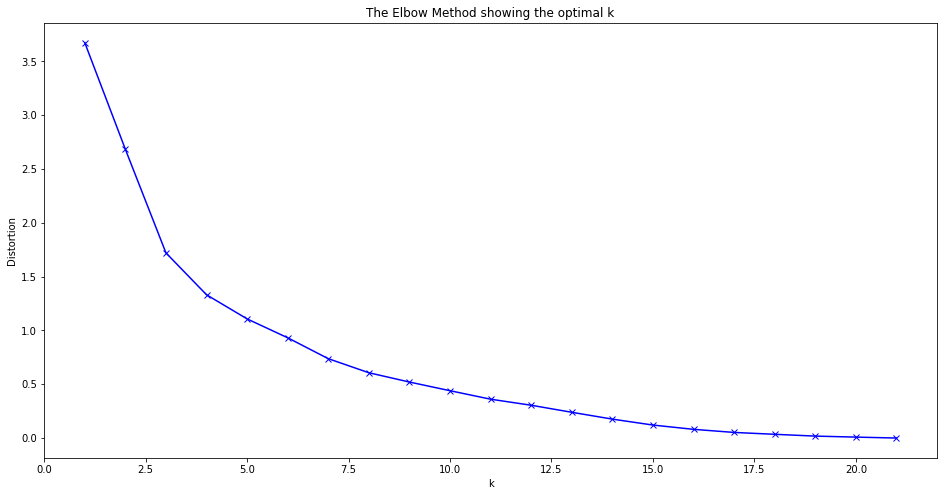

In [40]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

From above plot, best clusters will be 8-10, so using 9 clusters

In [41]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 7

dublin_grouped_clustering = dublin_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dublin_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:100]


array([4, 3, 0, 0, 4, 4, 0, 5, 0, 1, 4, 0, 2, 4, 4, 4, 4, 4, 4, 6, 0])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each postal district


In [42]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

dublin_merged = df_dublin

# merge dublin_grouped with df_dublin to add latitude/longitude for each neighborhood
dublin_merged = dublin_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighorhood')

dublin_merged.head() # check the last columns!

dublin_merged = dublin_merged.drop(dublin_merged.index[-1])

dublin_merged = dublin_merged.astype({"Cluster Labels": 'int32'})

In [122]:
dublin_merged

,Neighorhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Dublin 1,53.352488,-6.256646,4,Coffee Shop,Pub,Café,Italian Restaurant,Restaurant,Gastropub,Theater,Supermarket,Pizza Place,Sandwich Place
1,Dublin 2,53.338971,-6.252679,4,Coffee Shop,Café,Pub,Restaurant,Plaza,Cocktail Bar,Wine Shop,Steakhouse,Italian Restaurant,Japanese Restaurant
2,Dublin 3,53.361223,-6.185467,4,Grocery Store,Modern European Restaurant,Italian Restaurant,Fish & Chips Shop,Indian Restaurant,Café,Sports Club,Supermarket,Thai Restaurant,Coffee Shop
3,Dublin 4,53.327507,-6.227486,4,Pub,Coffee Shop,Café,Restaurant,Thai Restaurant,Indian Restaurant,Grocery Store,Italian Restaurant,Breakfast Spot,Pizza Place
4,Dublin 5,53.383454,-6.181923,4,Convenience Store,Gym,Sandwich Place,Café,Pharmacy,Sports Club,Supermarket,Chinese Restaurant,Burger Joint,Pub
5,Dublin 6,53.317698,-6.259525,4,Pub,Restaurant,Coffee Shop,Supermarket,Grocery Store,Fast Food Restaurant,Café,Pizza Place,Italian Restaurant,Thai Restaurant
6,Dublin 7,53.360551,-6.284470,4,Supermarket,Pub,Coffee Shop,Café,Bar,Gastropub,Soccer Stadium,Deli / Bodega,Pharmacy,Pizza Place
7,Dublin 6W,53.309282,-6.299435,4,Indian Restaurant,Bar,Breakfast Spot,Sandwich Place,Restaurant,Betting Shop,Grocery Store,Gym,Athletics & Sports,Convenience Store
8,Dublin 9,53.386050,-6.245577,0,Fast Food Restaurant,Coffee Shop,Pub,Supermarket,Betting Shop,Clothing Store,Asian Restaurant,Grocery Store,Convenience Store,Chinese Restaurant
9,Dublin 8,53.350263,-6.320213,6,Convenience Store,Café,Harbor / Marina,Other Great Outdoors,Wine Shop,Fast Food Restaurant,Flea Market,Fish Market,Fish & Chips Shop,Falafel Restaurant


Finally, let's visualize the resulting clusters

In [43]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        dublin_merged['latitude'], 
        dublin_merged['longitude'], 
        dublin_merged['Neighorhood'], 
        dublin_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

## 5. Examine Clusters

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we can then assign a name to each cluster. 

#### Cluster 1

In [44]:
dublin_merged.loc[dublin_merged['Cluster Labels'] == 0, dublin_merged.columns[[0] + list(range(4, dublin_merged.shape[1]))]]

,Neighorhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Dublin 9,Fast Food Restaurant,Coffee Shop,Pub,Supermarket,Betting Shop,Clothing Store,Asian Restaurant,Grocery Store,Convenience Store,Chinese Restaurant
10,Dublin 11,Hobby Shop,Supermarket,Pet Store,Coffee Shop,Fast Food Restaurant,Wine Shop,Farmers Market,Flea Market,Fish Market,Fish & Chips Shop
13,Dublin 12,Supermarket,Coffee Shop,Convenience Store,Café,Shopping Mall,Bistro,Fast Food Restaurant,Grocery Store,Pub,Diner
14,Dublin 15,Clothing Store,Supermarket,Fast Food Restaurant,Coffee Shop,Italian Restaurant,Asian Restaurant,Furniture / Home Store,Gym,Shoe Store,Sporting Goods Shop
16,Dublin 17,Supermarket,Fast Food Restaurant,Discount Store,Café,Coffee Shop,Mobile Phone Shop,Sandwich Place,Chocolate Shop,Wine Shop,Fish Market
19,Dublin 20,Supermarket,Coffee Shop,Convenience Store,Bowling Alley,Pub,Rental Car Location,Gym,Lingerie Store,Sandwich Place,Escape Room


#### Cluster 2

In [45]:
dublin_merged.loc[dublin_merged['Cluster Labels'] == 1, dublin_merged.columns[[0] + list(range(4, dublin_merged.shape[1]))]]

,Neighorhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Dublin 18,Bar,Wine Shop,Food Court,Food & Drink Shop,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Furniture / Home Store


#### Cluster 3

In [46]:
dublin_merged.loc[dublin_merged['Cluster Labels'] == 2, dublin_merged.columns[[0] + list(range(4, dublin_merged.shape[1]))]]

,Neighorhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Dublin 22,Cafeteria,Wine Shop,French Restaurant,Dim Sum Restaurant,Diner,Discount Store,Donut Shop,Escape Room,Falafel Restaurant,Farmers Market


#### Cluster 4

In [47]:
dublin_merged.loc[dublin_merged['Cluster Labels'] == 3, dublin_merged.columns[[0] + list(range(4, dublin_merged.shape[1]))]]

,Neighorhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Dublin 10,Supermarket,Grocery Store,Wine Shop,Farmers Market,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Falafel Restaurant,Food Court


#### Cluster 5

In [48]:
dublin_merged.loc[dublin_merged['Cluster Labels'] == 4, dublin_merged.columns[[0] + list(range(4, dublin_merged.shape[1]))]]

,Neighorhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Dublin 1,Coffee Shop,Pub,Café,Italian Restaurant,Restaurant,Gastropub,Theater,Supermarket,Pizza Place,Sandwich Place
1,Dublin 2,Coffee Shop,Café,Pub,Restaurant,Plaza,Cocktail Bar,Wine Shop,Steakhouse,Italian Restaurant,Japanese Restaurant
2,Dublin 3,Grocery Store,Modern European Restaurant,Italian Restaurant,Fish & Chips Shop,Indian Restaurant,Café,Sports Club,Supermarket,Thai Restaurant,Coffee Shop
3,Dublin 4,Pub,Coffee Shop,Café,Restaurant,Thai Restaurant,Indian Restaurant,Grocery Store,Italian Restaurant,Breakfast Spot,Pizza Place
4,Dublin 5,Convenience Store,Gym,Sandwich Place,Café,Pharmacy,Sports Club,Supermarket,Chinese Restaurant,Burger Joint,Pub
5,Dublin 6,Pub,Restaurant,Coffee Shop,Supermarket,Grocery Store,Fast Food Restaurant,Café,Pizza Place,Italian Restaurant,Thai Restaurant
6,Dublin 7,Supermarket,Pub,Coffee Shop,Café,Bar,Gastropub,Soccer Stadium,Deli / Bodega,Pharmacy,Pizza Place
7,Dublin 6W,Indian Restaurant,Bar,Breakfast Spot,Sandwich Place,Restaurant,Betting Shop,Grocery Store,Gym,Athletics & Sports,Convenience Store
12,Dublin 13,Seafood Restaurant,Pub,Café,Harbor / Marina,Deli / Bodega,Ice Cream Shop,Trail,Coffee Shop,Fish & Chips Shop,Bar
15,Dublin 14,Pizza Place,Pub,Supermarket,Shopping Mall,Grocery Store,History Museum,Food & Drink Shop,Department Store,Dim Sum Restaurant,Diner


#### Cluster 6

In [49]:
dublin_merged.loc[dublin_merged['Cluster Labels'] == 5, dublin_merged.columns[[0] + list(range(4, dublin_merged.shape[1]))]]

,Neighorhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Dublin 16,Pub,Rest Area,Trail,Café,Wine Shop,Falafel Restaurant,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market


#### Cluster 7

In [50]:
dublin_merged.loc[dublin_merged['Cluster Labels'] == 6, dublin_merged.columns[[0] + list(range(4, dublin_merged.shape[1]))]]

,Neighorhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Dublin 8,Convenience Store,Café,Harbor / Marina,Other Great Outdoors,Wine Shop,Fast Food Restaurant,Flea Market,Fish Market,Fish & Chips Shop,Falafel Restaurant


# Presentation

Merged two datasets to get cluster labels

In [51]:
dublin_clustering=dublin_venues.merge(dublin_merged, left_on='Neighborhood', right_on='Neighorhood',how='left')

Filtering for only required columns

In [52]:
dublin_clusters = dublin_clustering.loc[:, ['Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue','Venue Latitude'
                                            ,'Venue Longitude','Cluster Labels']]

In [53]:
dublin_clusters.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Cluster Labels
0,Dublin 1,53.352488,-6.256646,147 Deli,53.353410,-6.259807,4
1,Dublin 1,53.352488,-6.256646,The Celt,53.350442,-6.255071,4
2,Dublin 1,53.352488,-6.256646,The Hop House (Kim Chi),53.352981,-6.260772,4
3,Dublin 1,53.352488,-6.256646,Gate Theatre,53.353113,-6.261997,4
4,Dublin 1,53.352488,-6.256646,"Laine, my love",53.351320,-6.251253,4


Created a dataset for cluster 1

In [54]:
cluster1=dublin_clusters.loc[dublin_clusters['Cluster Labels'] == 0,:]
cluster1.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Cluster Labels
407,Dublin 9,53.38605,-6.245577,DCU Sports Complex,53.384659,-6.258340,0
408,Dublin 9,53.38605,-6.245577,The Helix,53.386624,-6.258461,0
409,Dublin 9,53.38605,-6.245577,Costa Coffee,53.392155,-6.247357,0
410,Dublin 9,53.38605,-6.245577,Lidl,53.394060,-6.248208,0
411,Dublin 9,53.38605,-6.245577,Starbucks,53.392696,-6.248581,0


Showing Cluster 1 venues on the Map 

In [55]:
map_cluster1 = folium.Map(location=[latitude, longitude], zoom_start=12)
for lat, lng, name in zip(
        cluster1['Venue Latitude'],
        cluster1['Venue Longitude'],
        cluster1['Venue']):
    label = '{}, {}'.format(name, 'Dublin')
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cluster1)  

map_cluster1

Creating dataset for Cluster 5

In [56]:
cluster5=dublin_clusters.loc[dublin_clusters['Cluster Labels'] ==4,:]
cluster5.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Cluster Labels
0,Dublin 1,53.352488,-6.256646,147 Deli,53.353410,-6.259807,4
1,Dublin 1,53.352488,-6.256646,The Celt,53.350442,-6.255071,4
2,Dublin 1,53.352488,-6.256646,The Hop House (Kim Chi),53.352981,-6.260772,4
3,Dublin 1,53.352488,-6.256646,Gate Theatre,53.353113,-6.261997,4
4,Dublin 1,53.352488,-6.256646,"Laine, my love",53.351320,-6.251253,4


Showing Cluster 5 venues on the map

In [57]:
map_cluster5 = folium.Map(location=[latitude, longitude], zoom_start=12)
for lat, lng, name in zip(
        cluster5['Venue Latitude'],
        cluster5['Venue Longitude'],
        cluster5['Venue']):
    label = '{}, {}'.format(name, 'Dublin')
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cluster5)  

map_cluster5

Creating dataset for remaining clusters

In [58]:
cluster_others=dublin_clusters.loc[(dublin_clusters['Cluster Labels']==1) | (dublin_clusters['Cluster Labels']==2) |
                                   (dublin_clusters['Cluster Labels']==3) | (dublin_clusters['Cluster Labels']==5)
                                   | (dublin_clusters['Cluster Labels']==6),:]
cluster_others.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Cluster Labels
440,Dublin 8,53.350263,-6.320213,Story Board,53.346089,-6.308190,6
441,Dublin 8,53.350263,-6.320213,Garda Boat Club,53.346330,-6.321328,6
442,Dublin 8,53.350263,-6.320213,The Yard Food Market,53.346197,-6.308143,6
443,Dublin 8,53.350263,-6.320213,Polo Grounds,53.356577,-6.309961,6
449,Dublin 10,53.343217,-6.360964,Lidl,53.344101,-6.371786,3


Showing remaining clusters venue on the map

In [59]:
map_cluster = folium.Map(location=[latitude, longitude], zoom_start=12)
for lat, lng, name in zip(
    cluster_others['Venue Latitude'],
    cluster_others['Venue Longitude'],
    cluster_others['Venue']):
    label = '{}, {}'.format(name, 'Dublin')
    
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cluster)  

map_cluster